In [1]:
%%capture
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Initialization cell
import os
import subprocess

import pandas as pd
import numpy as np

path_to_NPDtools = '/home/letovesnoi/work/tools/NPDtools-2.4.0-Linux/'

data_dir = 'data'
gnps_library = os.path.join(data_dir, 'GNPS-LIBRARY.mgf')
# gnps_library = os.path.join(data_dir, 'tst.mgf')

spectra_dir = os.path.join(data_dir, 'spectra')
mols_dir = os.path.join(data_dir, 'mols')
fthr = os.path.join(data_dir, 'data.fthr')

reg_run_dir = os.path.join(data_dir, 'REG_RUN_GNPS')
fdr0_tsv = os.path.join(reg_run_dir, 'regrun_fdr0_complete.tsv')
spectra_rr_dir = os.path.join(data_dir, 'spectra_REG_RUN')
reg_run_df = pd.read_csv(fdr0_tsv, sep="\t")
grouped_df = reg_run_df.groupby(['SpecFile'])['LocalSpecIdx', 'Structure'].agg(list)
fthr_rr = os.path.join(data_dir, 'data_rr.fthr')

discrete_masses = np.linspace(0, 5000, num=50000, dtype='float64')

In [2]:
# create directory for MGF files
if os.path.exists(spectra_dir):
    subprocess.call('rm -r {}'.format(spectra_dir), shell=True)
os.mkdir(spectra_dir)

# create directory for Molfiles
if os.path.exists(mols_dir):
    subprocess.call('rm -r {}'.format(mols_dir), shell=True)
os.mkdir(mols_dir)

In [10]:
def get_header(fin):
    header = []
    line = fin.readline()
    while '=' in line:
        ind = line.find('=')
        header.append((line[:ind], line[ind + 1:].strip()))
        line = fin.readline()
    return header, line

def get_spectrum(fin):
    header, line = get_header(fin)
    intensity = []
    while line != 'END IONS\n':
        intensity.append(line.strip().split())
        line = fin.readline()
    return header, np.array(intensity, dtype='float64')

def get_spectrum_id(header):
    return header[18][1]

def write_spectrum(header, intensity, spectrum_path):
    with open(spectrum_path, 'a') as fout:
        fout.write('BEGIN IONS\n')
        for key, value in header:
            fout.write(key + '=' + value + '\n')
        for mass, abundance in intensity:
            fout.write(str(mass) + ' ' + str(abundance) + '\n')
        fout.write('END IONS\n')

def split_mgf(gnps_library):
    spectra_pathes = []
    with open(gnps_library, 'r') as fin:
        num_spectra = 0
        while True:
            line = fin.readline()
            if not line:
                break
            num_spectra += 1
            header, intensity = get_spectrum(fin)
            spectra_pathes.append(os.path.join(spectra_dir, get_spectrum_id(header) + '.mgf'))
            write_spectrum(header, intensity, spectra_pathes[-1])
    # print('{} spectra'.format(num_spectra))
    return spectra_pathes

In [4]:
peptidic = 0
smiles_errors = 0
known = 0
empty = 0

def get_smiles(header):
    return header[11][1]

def get_mol(spectrum_path):
    with open(spectrum_path, 'r') as fin:
        fin.readline()
        header, intensity = get_spectrum(fin)
        molfile = os.path.join(mols_dir, get_spectrum_id(header) + '.mol')
        # print('SMILES=' + get_smiles(header))
        # print('SPECTRUMID=' + get_spectrum_id(header))
        subprocess.call('molconvert mol:V3+H -s \'{}\' -o {}'.format(get_smiles(header), molfile), shell=True)
    return molfile

def is_structural(mgf_file):
    global known
    with open(mgf_file, 'r') as fin:
        fin.readline()
        header, intensity = get_spectrum(fin)
        if get_smiles(header) == 'N/A' or get_smiles(header) == '':
            return False
        else:
            known += 1
            return True

def is_peptidic(molfile):
    global smiles_errors, peptidic
    tmp_peptidic = os.path.join(data_dir, 'peptidic.tmp')
    subprocess.call('{0}bin/print_structure {1} -C {0}share/npdtools/ --print_rule_fragmented_graph > {2}'.format(path_to_NPDtools, molfile, tmp_peptidic), shell=True)
    with open(tmp_peptidic, 'r') as fin:
        line = fin.readline()
        subprocess.call('rm {}'.format(tmp_peptidic), shell=True)
        if 'number of components' in line:
            num_components = line.strip().split(':')[1][1:]
        else:
            smiles_errors += 1
            print('{} contains an error'.format(molfile))
            return -1
    if int(num_components) > 3:
        peptidic += 1
        return 1
    else:
        return 0

def is_empty(mgf_file):
    global empty
    with open(mgf_file, 'r') as fin:
        fin.readline()
        header, intensity = get_spectrum(fin)
        if len(intensity) != 0:
            return False
        else:
            empty += 1
            print('{} has no information about intensity'.format(mgf_file))
            return True
        
def filter_spectra():
    for mgf_file in tqdm(split_mgf(gnps_library)):
        # remove unknown spectrum
        if not is_structural(mgf_file) or is_empty(mgf_file):
            subprocess.call('rm {}'.format(mgf_file), shell=True)
        else:
            molfile = get_mol(mgf_file)
            # remove non-peptidic data
            is_pep = is_peptidic(molfile)
            if is_pep == 0 or is_pep == -1:
                subprocess.call('rm {}'.format(mgf_file), shell=True)
                subprocess.call('rm {}'.format(molfile), shell=True)
                
filter_spectra()

print('{} have a known structure'.format(known))
print('{} have no information about intensity'.format(empty))
print('{} SMILES contains an error'.format(smiles_errors))
print('{} peptidic among structural, with non zero intensity, and with correct SMILES'.format(peptidic))

data/spectra/CCMSLIB00000078897.mgf has no information about intensity
data/mols/CCMSLIB00000478055.mol contains an error
data/mols/CCMSLIB00000478057.mol contains an error
data/mols/CCMSLIB00000478082.mol contains an error
data/mols/CCMSLIB00000478089.mol contains an error
data/mols/CCMSLIB00000478097.mol contains an error
data/mols/CCMSLIB00000478103.mol contains an error
data/spectra/CCMSLIB00000577483.mgf has no information about intensity
data/spectra/CCMSLIB00000577484.mgf has no information about intensity
data/spectra/CCMSLIB00000577485.mgf has no information about intensity
data/spectra/CCMSLIB00004722219.mgf has no information about intensity
data/mols/CCMSLIB00005435738.mol contains an error
data/mols/CCMSLIB00005436087.mol contains an error

2247 have a known structure
5 have no information about intensity
8 SMILES contains an error
443 peptidic among structural, with non zero intensity, and with correct SMILES


In [22]:
# linear, cyclic, branch-cyclic or complex
def get_fthr(spectra_pathes, fthr, discrete_masses):
    spectra_df = pd.DataFrame()
    for mgf_file in tqdm(spectra_pathes):
        with open(mgf_file, 'r') as fin:
            fin.readline()
            header, intensity = get_spectrum(fin)
        id = os.path.splitext(os.path.basename(mgf_file))[0]
#         bins = pd.cut(intensity[:, 0], bins=discrete_masses).astype(str)
        bins = pd.cut(intensity[:, 0], bins=discrete_masses, labels=False)
        spectrum_df = pd.DataFrame({id: intensity[:, 1], 'binned': bins}).groupby(['binned']).sum().T
        spectra_df = pd.concat([spectra_df, spectrum_df], sort=True)
    spectra_df.columns = spectra_df.columns.astype(str)
    spectra_df.reset_index().to_feather(fthr)
    return fthr

spectra_pathes = [os.path.join(spectra_dir, sp) for sp in os.listdir(spectra_dir)]

fthr = get_fthr(spectra_pathes, fthr, discrete_masses)

In [8]:
def split_mgf_by_ids(mgf_library, spectra_dir, local_ids):
    spectra_pathes = []
    with open(mgf_library, 'r') as fin:
        num_spectra = 0
        while True:
            line = fin.readline()
            if not line:
                break
            header, intensity = get_spectrum(fin)
            if num_spectra in local_ids:
                mgf_name = os.path.splitext(os.path.basename(mgf_library))[0]
                spectra_pathes.append(os.path.join(spectra_dir, mgf_name + '_' + str(num_spectra) + '.mgf'))
                write_spectrum(header, intensity, spectra_pathes[-1])
            num_spectra += 1
    return spectra_pathes

# create directory for MGF files
if os.path.exists(spectra_rr_dir):
    subprocess.call('rm -r {}'.format(spectra_rr_dir), shell=True)
os.mkdir(spectra_rr_dir)

spectra_rr_pathes = []
for index, row in grouped_df.iterrows():
    mgf_path = os.path.join(reg_run_dir, os.path.splitext(index)[0] + '_filtered.mgf')
    spectra_rr_pathes.extend(split_mgf_by_ids(mgf_path, spectra_rr_dir, row['LocalSpecIdx']))
    
fthr_rr = get_fthr(spectra_rr_pathes, fthr_rr, discrete_masses)

In [24]:
# Skip other cells except initialization and run this
spectra_pathes = [os.path.join(spectra_dir, sp) for sp in os.listdir(spectra_dir)]

spectra_rr_pathes = [os.path.join(spectra_rr_dir, sp) for sp in os.listdir(spectra_rr_dir)]

def get_df_from_files(fthr,  fthr_rr):
    spectra_df = pd.read_feather(fthr)
    del spectra_df['index']
    spectra_df.columns = pd.to_numeric(spectra_df.columns)

    spectra_rr_df = pd.read_feather(fthr_rr)
    del spectra_rr_df['index']
    spectra_rr_df.columns = pd.to_numeric(spectra_rr_df.columns)

    df = pd.concat([spectra_df, spectra_rr_df], sort=True)
    
    df = df.fillna(0)
    
    display(df)
    
    return df

df = get_df_from_files(fthr,  fthr_rr)

,344,404,424,440,445,449,450,451,452,453,...,30006,30014,30015,30017,30018,30025,30030,30033,30046,30047
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


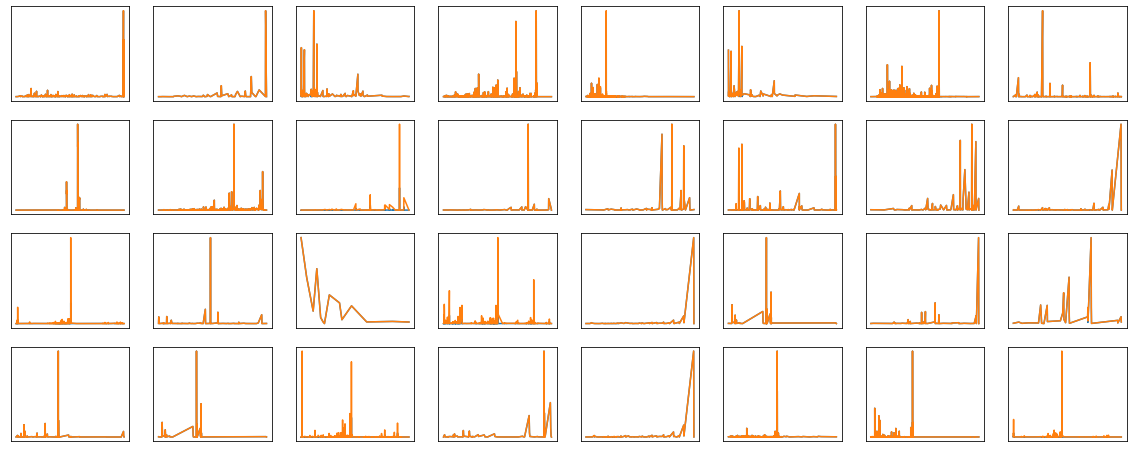

Discretization: 100



In [ ]:
# Skip it!  
import matplotlib.pyplot as plt

# Test discretisation
def plot_discretisation(tst_d_m=discrete_masses):
    i = 0
    fig = plt.figure(figsize=(20, 8))
    for mgf_file in tqdm(spectra_pathes):
        if i == 32:
            break
        ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        with open(mgf_file, 'r') as fin:
            fin.readline()
            header, intensity = get_spectrum(fin)
        id = os.path.splitext(os.path.basename(mgf_file))[0]
        ax.plot(intensity[:, 0], intensity[:, 1])
        bins = pd.cut(intensity[:, 0], bins=tst_d_m, labels=False)
        tst_df = pd.DataFrame({'intensity': intensity[:, 1], 'binned': bins}).groupby(['binned'], as_index=False).sum()
        tst_df['x'] = tst_df['binned'].transform(lambda b: tst_d_m[b])
        ax.plot(tst_df.x, tst_df.intensity)
        i += 1
    return ax
        
plt.show(plot_discretisation())


# Try different discretizations:
discr_list = [100, 500, 1000, 5000, 10000]
fthr_list = []
fthr_rr_list = []
df_list = []
for discr_n in discr_list:
    print('Discretization: {}\n'.format(discr_n))
    discr_m = np.linspace(0, 5000, num=discr_n, dtype='float64')
    
    fthr_d = os.path.join(data_dir, 'data.' + str(discr_n) + '.fthr')
    fthr_list.append(get_fthr(spectra_pathes, fthr_d, discr_m))
    
    fthr_rr_d = os.path.join(data_dir, 'data_rr.500.fthr')
    fthr_rr_list.append(get_fthr(spectra_rr_pathes, fthr_rr_d, discr_m))
    
    df_list.append(get_df_from_files(fthr_d,  fthr_rr_d))
    
    plt.show(plot_discretisation(discr_m))

In [4]:
# Get labels
def get_spectrum_cyclicality(molfile):
    tmp_cyclicality = os.path.join(data_dir, 'cyclicality.tmp')
    subprocess.call('{0}bin/print_structure {1} -C {0}share/npdtools/ --print_structure > {2}'.format(path_to_NPDtools, molfile, tmp_cyclicality), shell=True)
    with open(tmp_cyclicality, 'r') as fin:
        cyclicality = fin.readline().strip()
    subprocess.call('rm {}'.format(tmp_cyclicality), shell=True)
    return cyclicality

cycl_dict = {'linear': 0, 'cyclic': 1, 'b-cyclic': 2, 'branch-cyclic': 2, 'complex': 3}

def get_labels(mols_dir):
    labels = []
    for molfile in tqdm(os.listdir(mols_dir)):
        cyclicality = get_spectrum_cyclicality(os.path.join(mols_dir, molfile))
        labels.append(cycl_dict[cyclicality])
    return labels    

def get_labels_rr(grouped_df):
    labels = []
    for index, row in grouped_df.iterrows():
        labels.extend([cycl_dict[cyclicality] for cyclicality in row['Structure']])
    return labels

labels = get_labels(mols_dir) + get_labels_rr(grouped_df)

print('{} linear'.format(labels.count(0)))
print('{} cyclic'.format(labels.count(1)))
print('{} branch-cyclic'.format(labels.count(2)))
print('{} complex'.format(labels.count(3)))


3186 linear
2763 cyclic
1763 branch-cyclic
236 complex


In [5]:
import keras

from sklearn.model_selection import train_test_split

X = df.to_numpy().astype('float32')
y = np.array(labels).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(X_train.shape)

Using TensorFlow backend.


(5325, 23325, 1)


In [6]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
# model.add(Conv2D(filters=4, kernel_size=4, padding='same', activation='relu', input_shape=(1, 23325, 1)))
# model.add(MaxPooling2D(pool_size=(1, 2)))
# model.add(Conv2D(filters=4, kernel_size=4, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(1,2)))
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='relu', input_shape=(23325, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 23325, 16)         80        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11662, 16)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11662, 32)         2080      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5831, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5831, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186592)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                11941952  
__________

In [7]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [8]:
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
y = [y_t.argmax() for y_t in y_train]
w = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(y), y)))
print('class weight = ', w, '\n')
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.25, 
                 callbacks=[checkpointer], verbose=2, shuffle=True, class_weight=w)

class weight =  {0: 0.6191860465116279, 1: 0.7238988580750407, 2: 1.1158843252305113, 3: 9.30944055944056} 

Train on 3993 samples, validate on 1332 samples
Epoch 1/10
 - 54s - loss: 1.3949 - acc: 0.3348 - val_loss: 1.4325 - val_acc: 0.3273

Epoch 00001: val_loss improved from inf to 1.43249, saving model to model.weights.best.hdf5
Epoch 2/10
 - 37s - loss: 1.3712 - acc: 0.3093 - val_loss: 1.4328 - val_acc: 0.3273

Epoch 00002: val_loss did not improve from 1.43249
Epoch 3/10
 - 42s - loss: 1.3713 - acc: 0.3318 - val_loss: 1.4334 - val_acc: 0.3273

Epoch 00003: val_loss did not improve from 1.43249
Epoch 4/10
 - 39s - loss: 1.3706 - acc: 0.3504 - val_loss: 1.4341 - val_acc: 0.3273

Epoch 00004: val_loss did not improve from 1.43249
Epoch 5/10
 - 37s - loss: 1.3711 - acc: 0.3499 - val_loss: 1.4347 - val_acc: 0.3273

Epoch 00005: val_loss did not improve from 1.43249
Epoch 6/10
 - 37s - loss: 1.3710 - acc: 0.3506 - val_loss: 1.4348 - val_acc: 0.3273

Epoch 00006: val_loss did not improve

In [9]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [10]:
# evaluate and print test accuracy
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.35226839481988936


In [11]:
# get predictions on the test set
y_hat = model.predict(X_test)

In [12]:
import matplotlib.pyplot as plt

# define text labels
names = ['linear', 'cyclic','b-cyclic', 'complex']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, rc_i in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])    
    x = np.array([discrete_masses[int(bin_i)] for bin_i in df.columns.values.tolist()])
    y = np.array(np.squeeze(X_test[rc_i]))  
    y_mask = np.isfinite(y)
    ax.plot(x[y_mask], y[y_mask])
    pred_idx = np.argmax(y_hat[rc_i])
    true_idx = np.argmax(y_test[rc_i])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]), 
                 color=("green" if pred_idx == true_idx else "red"))